# Predicting the Future of COVID-19 with Machine Learning

## Introduction

As of August 2020, the COVID-19 pandemic has claimed over 760,000 lives across the world and over 13 million people have been infected. Understanding the factors and policies that influence the spread of the virus can help governments make informed decisions in order to control infections and deaths until a vaccine is being developed.

The goal of this article is to answer the following questions:

- **What are the factors and policies that have the greatest impact on the number of cases and deaths across the world?**
- **How can we predict the number of COVID-19 cases, deaths, and recoveries in the future?**

## Datasets


In order to answer the questions above, I aggregated data from the following sources:
- Johns Hopkins CCSE Covid-19 Data Repository: https://github.com/CSSEGISandData/COVID-19
- Policy Data From  Oxford Coronavirus Government Response Tracker (OxCGRT): https://ourworldindata.org/policy-responses-covid

I used data aggregated from both sources to train a model that can forecast the number of COVID-19 cases, deaths, and recoveries in any nation months into the future based on a wide range of factors including:
- **GDP**
- **Government response to the coronavirus, including stay-at-home and social distancing restrictions.**
- **The change in mobility of its population since the start of the pandemic.**
- **Demographic data about its population.**
- **Past data regarding the number of cases, deaths, and recoveries.**


## Import Libraries

In [1]:
import numpy as np
import math
import datapane as dp
import pandas as pd
from collections import defaultdict
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import plotly.express as px
import plotly.io as pio
from matplotlib.cm import get_cmap
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode(connected=True)
import pycountry
import pyprind
from datetime import timedelta
from pycountry import countries
from geopy.geocoders import Nominatim
from datetime import datetime
from yellowbrick.regressor import ResidualsPlot
from joblib import load, dump
import warnings
warnings.filterwarnings("ignore")
import chart_studio.plotly as py
import chart_studio
username = os.environ['PLOTLY_USERNAME']
api_key = os.environ['PLOTLY_API_KEY']
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

%matplotlib inline

/Users/amol/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
fig = go.Figure(go.Indicator(
    value = 0.9,
    mode = "gauge+number",
    title = {'text': "R^2 Score for Confirmed Cases"},
    gauge = {'bar': {'color': "lightgreen"},
        'axis': {'range': [None, 1]},
             'steps' : [
                 {'range': [0, 0.5], 'color': "lightgray"},
                 {'range': [0.5, 1], 'color': "gray"}],
          }))
fig.show()

## Read Data

In [3]:
covid_19_data = pd.read_csv('./data/covid_19_data.csv')
confirmed_cases = pd.read_csv('./data/time_series_covid_19_confirmed.csv')
deaths = pd.read_csv('./data/time_series_covid_19_deaths.csv')
recovered = pd.read_csv('./data/time_series_covid_19_recovered.csv')
confirmed_cases_us = pd.read_csv('./data/time_series_covid_19_confirmed_US.csv')
owid_covid_data = pd.read_csv('./data/owid-covid-data.csv')


mobility_data = defaultdict()

mobility_data['visitors_grocery_stores'] = pd.read_csv('./data/change-visitors-grocery-stores.csv')
mobility_data['visitors_parks_covid'] = pd.read_csv('./data/change-visitors-parks-covid.csv')
mobility_data['visitors_retail'] = pd.read_csv('./data/change-visitors-retail-recreation.csv')
mobility_data['residential_duration'] = pd.read_csv('./data/changes-residential-duration-covid.csv')
mobility_data['changes_visitors'] = pd.read_csv('./data/changes-visitors-covid.csv')


policy_data = defaultdict()

policy_data['public_events_policies'] = pd.read_csv('./data/public-events-covid.csv')
policy_data['public_gathering_policies'] = pd.read_csv('./data/public-gathering-rules-covid.csv')
policy_data['public_information_campaigns'] = pd.read_csv('./data/public-campaigns-covid.csv')
policy_data['public_transport_policies'] = pd.read_csv('./data/public-transport-covid.csv')
policy_data['school_closures'] = pd.read_csv('./data/school-closures-covid.csv')
policy_data['work_closures'] = pd.read_csv('./data/workplace-closures-covid.csv')
policy_data['stay_at_home_policies'] = pd.read_csv('./data/stay-at-home-covid.csv')
policy_data['contract_tracing'] = pd.read_csv('./data/covid-contact-tracing.csv')
policy_data['debt_relief'] = pd.read_csv('./data/debt-relief-covid.csv')
policy_data['income_support'] = pd.read_csv('./data/income-support-covid.csv')
policy_data['internal_movement'] = pd.read_csv('./data/internal-movement-covid.csv')
policy_data['international_travel'] = pd.read_csv('./data/international-travel-covid.csv')
policy_data['testing_policy'] = pd.read_csv('./data/covid-19-testing-policy.csv')

## Preprocessing Data

### Merging Policy Data and Mobility Data

In [4]:
def get_merged_data(data_dict):
    
    dataframes = list(data_dict.values())
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Entity', 'Code', 'Date'],
                                            how='inner'), dataframes)
    
    return df_merged

def merge_dataframes(dfs, merge_cols):
    
    
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=merge_cols,
                                            how='inner'), dfs)
    
    return df_merged

def filter_by_country(data, country):
    
    return data[data['Country/Region'] == country]

In [5]:
merged_policy_data = get_merged_data(policy_data)
merged_policy_data['Date'] = pd.to_datetime(merged_policy_data['Date'])
merged_policy_data.rename(columns={'Entity': 'Country/Region'}, inplace=True)
merged_policy_data.iloc[100:110]

Country/Region Code       Date  Cancel public events (OxBSG)  \
100    Afghanistan  AFG 2020-04-10                             2   
101    Afghanistan  AFG 2020-04-11                             2   
102    Afghanistan  AFG 2020-04-12                             2   
103    Afghanistan  AFG 2020-04-13                             2   
104    Afghanistan  AFG 2020-04-14                             2   
105    Afghanistan  AFG 2020-04-15                             2   
106    Afghanistan  AFG 2020-04-16                             2   
107    Afghanistan  AFG 2020-04-17                             2   
108    Afghanistan  AFG 2020-04-18                             2   
109    Afghanistan  AFG 2020-04-19                             2   

     Restrictions on gatherings (OxBSG)  Public information campaigns (OxBSG)  \
100                                   4                                     2   
101                                   4                                     2   
102                                   4                                     2   
103                                   4                                     2   
104                                   4                                     2   
105                                   4                                     2   
106                                   4                                     2   
107                                   4                                     2   
108                                   4                                     2   
109                                   4                                     2   

     Close public transport (OxBSG)  School closures  \
100                               2                3   
101                               2                3   
102                               2                3   
103                               2                3   
104                               2                3   
105                               2                3   
106                               2                3   
107                               2                3   
108                               2                3   
109                               2                3   

     Workplace Closures (OxBSG)  Stay at home requirements (OxBSG)  \
100                           3                                  2   
101                           3                                  2   
102                           3                                  2   
103                           3                                  2   
104                           3                                  2   
105                           3                                  2   
106                           3                                  2   
107                           3                                  2   
108                           3                                  2   
109                           3                                  2   

     Contact tracing (OxBSG)  Debt or contract relief  Income support  \
100                        1                        0               0   
101                        1                        0               0   
102                        1                        0               0   
103                        1                        0               0   
104                        1                        0               0   
105                        1                        0               0   
106                        1                        0               0   
107                        1                        0               0   
108                        1                        0               0   
109                        1                        0               0   

     Restrictions on internal movement (OxBSG)  \
100                                          1   
101                                          1   
102                  

In [6]:
def fill_forward_data(data, end_date):
    
    countries = list(data['Country/Region'].unique())
    dataframes = []
    
    for country in countries:
        country_data = filter_by_country(data, country)
        last_date = country_data['Date'].max()
        latest_data = data[data['Date'] == last_date] 
        time_diff = (end_date - last_date).days
        
        
        for days in range(1, time_diff + 1):
            new_date = last_date + timedelta(days)
            new_data = latest_data
            new_data['Date'] = new_date
            country_data = country_data.append(new_data)
            #print(country_data['Date'].max())
        
        dataframes.append(country_data)
    
    return pd.concat(dataframes)

In [7]:
merged_mobility_data = get_merged_data(mobility_data)
merged_mobility_data['Date'] = pd.to_datetime(merged_mobility_data['Date'])
merged_mobility_data.rename(columns={'Entity': 'Country/Region'}, inplace=True)
merged_mobility_data = fill_forward_data(merged_mobility_data, end_date = merged_policy_data['Date'].max())
merged_policy_data = pd.merge(merged_policy_data, merged_mobility_data,
                              how='left', 
                              left_on=['Country/Region','Code','Date'], 
                              right_on = ['Country/Region','Code','Date']).fillna(0)

### Transforming Case, Deaths, and Recovered Stats

In [8]:
def group_stats_by_country(df):
    
    cols = list(df.columns[4:])
    country_stats = df.groupby('Country/Region').sum()
    countries = list(country_stats.index)
    
    country_stats['Country/Region'] = countries
        
    #return country_stats.drop(['Lat', 'Long'], axis=1)
    return country_stats

case_stats = group_stats_by_country(confirmed_cases)
deaths_stats = group_stats_by_country(deaths)
recovered_stats = group_stats_by_country(recovered)

def add_date_column(df, metric_name='confirmed_cases'):
    
    data_dict = defaultdict()
    data_dict['Country/Region'] = []
    data_dict['Date'] = []
    data_dict[metric_name] = []
    
    date_cols = list(filter((lambda x: x.count('/') == 2), list(df.columns)))
    n = len(date_cols)
    
    for index, row in df.iterrows():
        country = [row['Country/Region']] * n
        metric_values = list(row[date_cols])
        
        data_dict['Country/Region'] = data_dict['Country/Region'] + country
        data_dict['Date'] = data_dict['Date'] + date_cols
        data_dict[metric_name] = data_dict[metric_name] + metric_values
        
        
    return pd.DataFrame(data_dict)




In [9]:
case_stats_by_date = add_date_column(case_stats, metric_name='confirmed_cases')
deaths_stats_by_date = add_date_column(deaths_stats, metric_name='deaths')
recovered_stats_by_date = add_date_column(recovered_stats, metric_name='recovered')

dataframes = [case_stats_by_date, deaths_stats_by_date, recovered_stats_by_date]
all_stats_by_date = merge_dataframes(dataframes, merge_cols=['Country/Region', 'Date'])
all_stats_by_date['Date'] = pd.to_datetime(all_stats_by_date['Date'])
all_stats_by_date.iloc[100:110]

Country/Region       Date  confirmed_cases  deaths  recovered
100    Afghanistan 2020-05-01             2335      68        310
101    Afghanistan 2020-05-02             2469      72        331
102    Afghanistan 2020-05-03             2704      85        345
103    Afghanistan 2020-05-04             2894      90        397
104    Afghanistan 2020-05-05             3224      95        421
105    Afghanistan 2020-05-06             3392     104        458
106    Afghanistan 2020-05-07             3563     106        468
107    Afghanistan 2020-05-08             3778     109        472
108    Afghanistan 2020-05-09             4033     115        502
109    Afghanistan 2020-05-10             4402     120        558

### Generating Country Codes

In [10]:
code_dict = defaultdict()

def get_country_code(country):
    
    exceptions = {'laos': 'LAO', 
                  'burma': 'MMR', 
                  'congo (brazzaville)': 'COG', 
                  'congo (kinshasa)': 'COD',
                  'korea, south': 'KOR',
                  'diamond princess': 'DMD_PRCS',
                  'ms zaandam': 'MS_ZAND',
                  'taiwan*': 'TWN',
                  'west bank and gaza': 'PSE'}
    
    try:
        try:
            return code_dict[country]
        except:   
            code = countries.search_fuzzy(country)[0].alpha_3
            code_dict[country] = code
            return code
    except:
        if type(country) == float:
            return country
        else:
            code = exceptions[country.lower()]
            code_dict[country] = code
            return code


In [11]:
policy_countries = list(merged_policy_data['Country/Region'].unique())

In [12]:
all_stats_by_date['Code'] = all_stats_by_date['Country/Region'].map(get_country_code)

### Getting Accurate Latitude and Longitude Coordinates

In [13]:
geolocator = Nominatim(user_agent="forecasting_app")
countries = list(all_stats_by_date['Country/Region'].unique())

def create_coordinate_dict(countries):
    
    location_dict = defaultdict()
    for country in countries:
        location = geolocator.geocode(country)
        location_dict[country] = {'latitude': location.latitude, 'longitude': location.longitude}
    
    return location_dict

def get_latitude(country, location_dict):
    
    return location_dict[country]['latitude']

def get_longitude(country, location_dict):
    
    return location_dict[country]['longitude']

location_dict = create_coordinate_dict(countries)

all_stats_by_date['Lat'] = all_stats_by_date['Country/Region'].map(lambda x: get_latitude(x, location_dict))
all_stats_by_date['Long'] = all_stats_by_date['Country/Region'].map(lambda x: get_longitude(x, location_dict))

### Merging Policy Data and Cases, Deaths, and Recovery Statistics

In [14]:
factor_data_by_date = merge_dataframes([all_stats_by_date, merged_policy_data], merge_cols=['Code', 'Date'])
factor_data_by_date.drop('Country/Region_y', axis=1, inplace=True)
factor_data_by_date.rename(columns={'Country/Region_x': 'Country/Region'}, inplace=True)

### Adding Additional Fields

In [15]:
owid_covid_data['date'] = pd.to_datetime(owid_covid_data['date'])
owid_covid_data.head(10)

iso_code continent     location       date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan 2019-12-31          0.0        0.0   
1      AFG      Asia  Afghanistan 2020-01-01          0.0        0.0   
2      AFG      Asia  Afghanistan 2020-01-02          0.0        0.0   
3      AFG      Asia  Afghanistan 2020-01-03          0.0        0.0   
4      AFG      Asia  Afghanistan 2020-01-04          0.0        0.0   
5      AFG      Asia  Afghanistan 2020-01-05          0.0        0.0   
6      AFG      Asia  Afghanistan 2020-01-06          0.0        0.0   
7      AFG      Asia  Afghanistan 2020-01-07          0.0        0.0   
8      AFG      Asia  Afghanistan 2020-01-08          0.0        0.0   
9      AFG      Asia  Afghanistan 2020-01-09          0.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           0.0         0.0                  NaN  ...   
1                 NaN           0.0         0.0                  NaN  ...   
2                 NaN           0.0         0.0                  NaN  ...   
3                 NaN           0.0         0.0                  NaN  ...   
4                 NaN           0.0         0.0                  NaN  ...   
5                 NaN           0.0         0.0                  NaN  ...   
6                 0.0           0.0         0.0                  0.0  ...   
7                 0.0           0.0         0.0                  0.0  ...   
8                 0.0           0.0         0.0                  0.0  ...   
9                 0.0           0.0         0.0                  0.0  ...   

   aged_70_older  gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0          1.337        1803.987              NaN                597.029   
1          1.337        1803.987              NaN                597.029   
2          1.337        1803.987              NaN                597.029   
3          1.337        1803.987              NaN                597.029   
4          1.337        1803.987              NaN                597.029   
5          1.337        1803.987              NaN                597.029   
6          1.337        1803.987              NaN                597.029   
7          1.337        1803.987              NaN                597.029   
8          1.337        1803.987              NaN                597.029   
9          1.337        1803.987              NaN                597.029   

   diabetes_prevalence  female_smokers  male_smokers  handwashing_facilities  \
0                 9.59             NaN           NaN                  37.746   
1                 9.59             NaN           NaN                  37.746   
2                 9.59             NaN           NaN                  37.746   
3                 9.59             NaN           NaN                  37.746   
4                 9.59             NaN           NaN                  37.746   
5                 9.59             NaN           NaN                  37.746   
6                 9.59             NaN           NaN                  37.746   
7                 9.59             NaN           NaN                  37.746   
8                 9.59             NaN           NaN                  37.746   
9                 9.59             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  
0                         0.5            64.83  
1                         0.5            64.83  
2                         0.5            64.83  
3                         0.5            64.83  
4                         0.5            64.83  
5                         0.5            64.83  
6                         0.5            64.83  
7                         0.5            64.83  
8                         0.5            64.83  
9                         0.5            64.83  

[10 rows x 40 columns]

In [16]:
all_stats_by_date['Date'].max()

Timestamp('2020-09-02 00:00:00')

In [17]:
all_data_by_date = pd.merge(factor_data_by_date, owid_covid_data,
         how='left', 
         left_on=['Code','Date'], 
         right_on = ['iso_code','date'])

### Computing Differences

In [18]:
def compute_diffs(df, split_col='Code', fields=['confirmed_cases', 'deaths', 'recovered']):
    
    data_dict = defaultdict()
    codes = (df[split_col].unique())
    
    for code in codes:
        df_code = df[df[split_col] == code]
        
        for field in fields:
            df_code[field + '_diff'] = np.diff(df_code[field], prepend = 0)
        
        data_dict[code] = df_code
    
    return pd.concat(list(data_dict.values()))

In [19]:
all_data_by_date_diffs = compute_diffs(all_data_by_date)

## Exploratory Data Analysis and Visualizations

### Setting up Visualization Color Cycle and Formatting Datetime Columns

In [20]:
from datetime import datetime
dates = confirmed_cases.columns[4:].map(lambda date: datetime.strptime(date, '%m/%d/%y'))

In [21]:
from matplotlib.colors import hsv_to_rgb
from cycler import cycler

# 1000 distinct colors:
colors = [hsv_to_rgb([(i * 0.618033988749895) % 1.0, 1, 1])
          for i in range(1000)]
plt.rc('axes', prop_cycle=(cycler('color', colors)))

### Visualizing Case Counts on a Map

In [22]:
fig = px.choropleth(case_stats_by_date, 
                    animation_frame = 'Date',
                    locations = 'Country/Region', 
                    locationmode = 'country names',
                    color_continuous_scale = "blues",
                    color = 'confirmed_cases',
                    title='COVID-19 Cases')

fig.show()
report = dp.Report(dp.Plot(fig) ) #Create a report
report.publish(name='covid_cases', open=True, visibility='PUBLIC') #Publish the report
#pio.write_html(fig, file = './visualizations/covid_cases_by_date.html', auto_open=True)
#fig.show("svg")
#fig.write_image('./visualizations/confirmed_cases.svg')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/AmolMavuduru/reports/covid_cases/


### Visualizing Deaths on a Map

In [23]:
fig = px.choropleth(deaths_stats_by_date,
                    animation_frame = 'Date',
                    locations = 'Country/Region', 
                    locationmode = 'country names',
                    color_continuous_scale = "reds",
                    color = 'deaths',
                    title='COVID-19 Deaths')

fig.show()
report = dp.Report(dp.Plot(fig) ) #Create a report
report.publish(name='covid_deaths', open=True, visibility='PUBLIC') #Publish the report
#py.plot(fig, filename = 'covid_deaths_by_date', auto_open=True)
#fig.show("svg")
#fig.write_image('./visualizations/deaths.svg')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/AmolMavuduru/reports/covid_deaths/


### Visualizing Recovered Cases on a Map

In [24]:
fig = px.choropleth(recovered_stats_by_date,
                    animation_frame = 'Date',
                    locations = 'Country/Region', 
                    locationmode = 'country names',
                    color_continuous_scale = "greens",
                    color = 'recovered',
                    title='COVID-19 Recovered Cases')

fig.show()
report = dp.Report(dp.Plot(fig) ) #Create a report
report.publish(name='covid_recoveries', open=True, visibility='PUBLIC') #Publish the report
#py.plot(fig, filename = 'covid_recoveries_by_date', auto_open=True)
#fig.show("svg")
#fig.write_image('./visualizations/recovered.svg')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/AmolMavuduru/reports/covid_recoveries/


### Defining Utility Functions

In [25]:
def plot_columns(data, country, columns):
    
    country_data = data[data['Country/Region'] == country]
    plt.figure(figsize=(15, 10))
    for column in columns:
        plt.plot(country_data['Date'], country_data[column], label=column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend(loc='best')
    plt.title('Trends for {}'.format(country))
    plt.show()
    
def filter_by_country(data, country):
    
    return data[data['Country/Region'] == country]

In [26]:
def get_policy_counts(data):
    
    policy_counts_dict = defaultdict()
    policy_cols = list(filter(lambda x: 'OxBSG' in x, list(data.columns)))
    
    data_one_hot = pd.get_dummies(data, columns=policy_cols)
    new_policy_cols = list(filter(lambda x: 'OxBSG' in x, list(data_one_hot.columns)))
    
    countries = data['Country/Region'].unique()
    
    for col in new_policy_cols + ['Country/Region']:
        policy_counts_dict[col] = []
        
        
    for country in countries:
        policy_counts_dict['Country/Region'].append(country)
        country_data = filter_by_country(data_one_hot, country=country)
        policy_counts = country_data[new_policy_cols].sum()
        for col in new_policy_cols:
            policy_counts_dict[col].append(policy_counts[col])
            
    
    return pd.DataFrame(policy_counts_dict)

policy_counts_data = get_policy_counts(all_data_by_date_diffs)

## What measures are most effective at slowing the spread of COVID-19?

### Creating Country Profiles

In order to understand the policies and factors that are most effective at slowing the spread of COVID-19, we can look at the differences in COVID-19 statistics among different countries and compare the policies and demographic data for each country. By creating a profile for each country with policy and demographic information along with COVID-19 statistics, we can find out what policies are most effective at controlling COVID-19 and what types of countries were hardest hit by the pandemic. We can then train a tree-based model such as XGBoost to predict COVID-19 statistics based on the policy and demographic data in a given country and use the model to determine the importance of each feature.

In [27]:
def create_country_profiles(data, drop_cols):
    
    policy_cols = list(filter(lambda x: 'OxBSG' in x, list(data.columns)))
    last_date = data['Date'].max()
    latest_data = data[data['Date'] == last_date]
    policy_counts_data = get_policy_counts(data)
    original_policy_cols = list(filter(lambda x: 'OxBSG' in x, list(latest_data.columns)))
    latest_data.drop(policy_cols, axis=1, inplace=True)
    
    country_profiles = pd.merge(latest_data, policy_counts_data, 
         how='inner', 
         on=['Country/Region'])
    
    country_profiles.drop(drop_cols, axis=1, inplace=True)
    
    return country_profiles  

In [28]:
drop_cols = ['total_cases', 'new_cases', 'new_cases_smoothed',
             'new_deaths_smoothed', 'new_deaths_smoothed_per_million',
             'total_deaths', 'new_tests_smoothed_per_thousand',
             'new_tests_smoothed', 'date', 'iso_code', 'new_tests',
             'new_deaths', 'tests_per_case', 'new_cases_smoothed_per_million', 'new_deaths_per_million']

country_profiles = create_country_profiles(all_data_by_date_diffs, drop_cols)

In [29]:
country_profiles = pd.get_dummies(country_profiles, columns=['tests_units'])

### Training XGBoost Model to Gauge Feature Importance

In [30]:
from xgboost import XGBRegressor, plot_importance
xgb = XGBRegressor(n_estimators=50)

### What factors have the greatest overall impact on the total number of confirmed cases?

With the total number of confirmed as the target variable, we can train an XGBoost model and use it identify which factors and policies have the greatest overall impact on the total number of cases in any given country. 

In [31]:
def build_importance_plot(X, y):
    
    xgb = XGBRegressor(n_estimators=50)
    xgb.fit(X, y)
    
    fig, ax = plt.subplots(figsize=(10, 15))
    plot_importance(xgb, max_num_features=30, ax=ax)

In [32]:
X = country_profiles.drop(['confirmed_cases_diff', 'deaths_diff', 'Code', 
                          'recovered_diff', 'deaths', 'recovered', 'confirmed_cases',
                           'total_deaths_per_million', 'total_cases_per_million',
                          'continent', 'location', 'Country/Region', 'Date', 'Lat', 'Long'], axis=1)

y = country_profiles['confirmed_cases']

In [33]:
xgb.fit(X, y)

[13:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

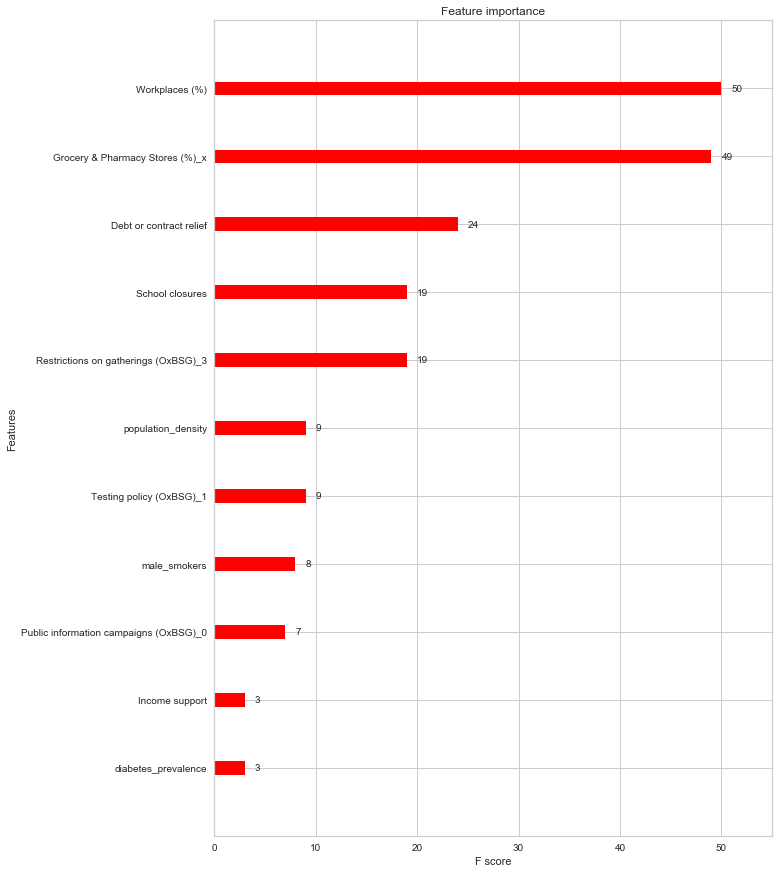

In [34]:
fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(xgb, max_num_features=30, ax=ax)

### What factors have the greatest impact on the total number of deaths?

We can repeat this same process, this time using the total number of deaths as the target variable to find out which factors have the greatest impact on the total number of deaths.

[13:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


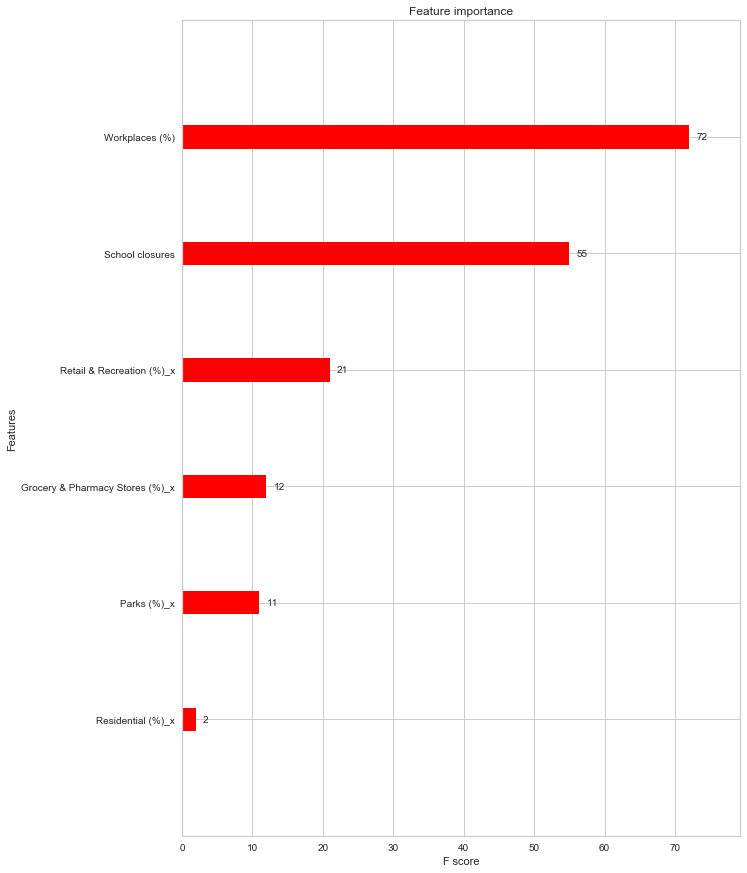

In [35]:
X = country_profiles.drop(['confirmed_cases_diff', 'deaths_diff', 'Code', 
                          'recovered_diff', 'deaths', 'recovered', 'confirmed_cases',
                           'total_deaths_per_million', 'total_cases_per_million',
                          'continent', 'location', 'Country/Region', 'Date', 'Lat', 'Long'], axis=1)

y = country_profiles['deaths']

build_importance_plot(X, y)

### What factors have the greatest impact on the total number of recovered cases?

We can repeat this same process, this time using the total number of recoveries as the target variable to find out which factors have the greatest impact on the total number of recoveries.

[13:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


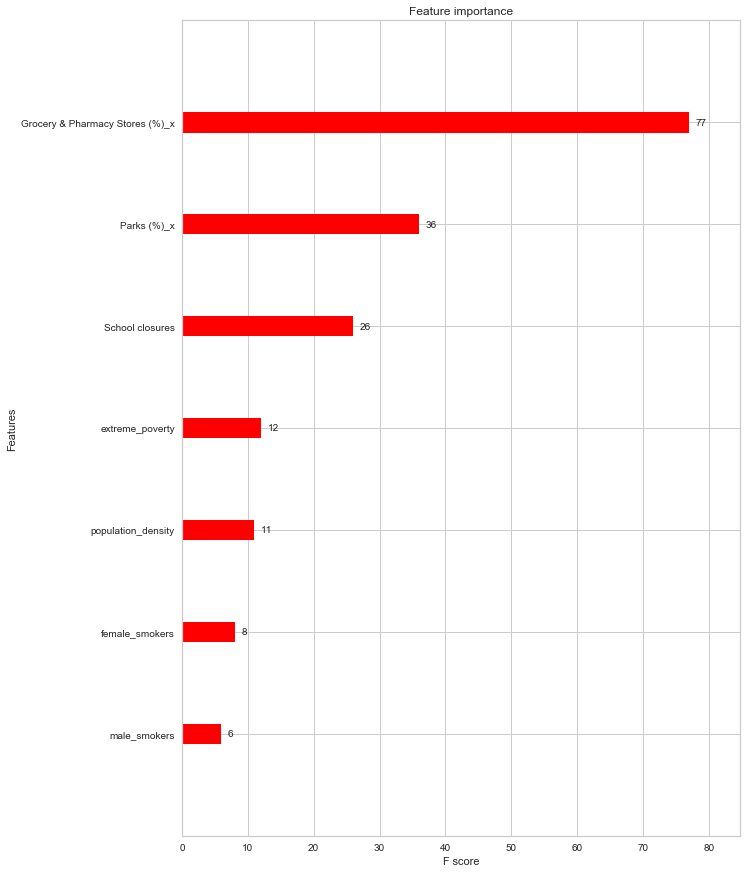

In [36]:
X = country_profiles.drop(['confirmed_cases_diff', 'deaths_diff', 'Code',
                          'recovered_diff', 'deaths', 'recovered', 'confirmed_cases',
                           'total_deaths_per_million', 'total_cases_per_million',
                          'continent', 'location', 'Country/Region', 'Date', 'Lat', 'Long'], axis=1)

y = country_profiles['recovered']

build_importance_plot(X, y)

### What factors have the greatest impact on the total number of confirmed cases per million people?

[13:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


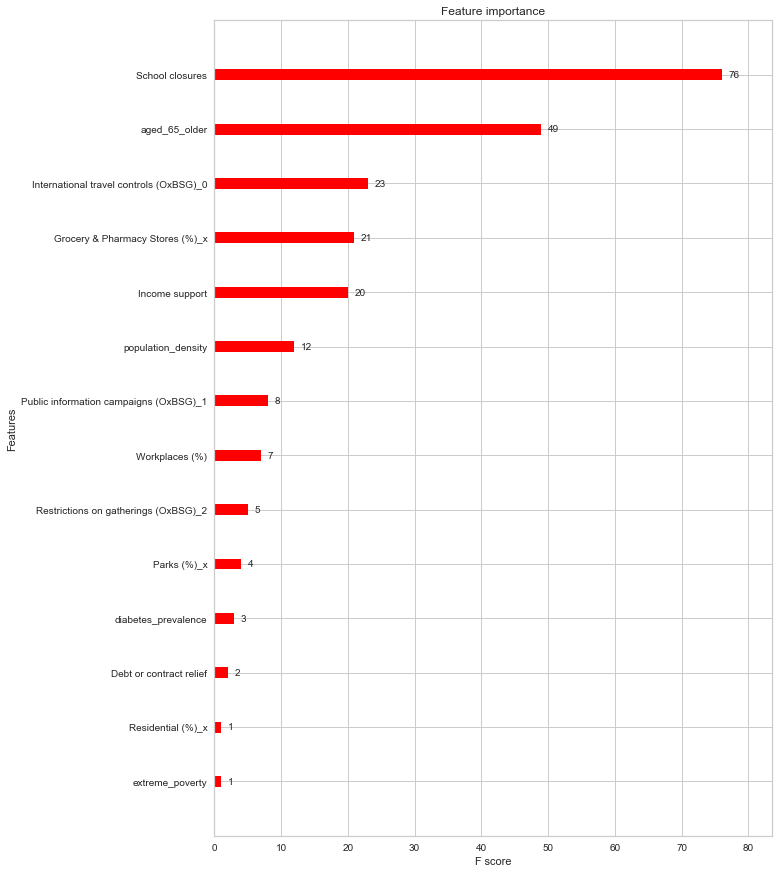

In [37]:
X = country_profiles.drop(['confirmed_cases_diff', 'deaths_diff', 'Code',
                          'recovered_diff', 'deaths', 'recovered', 'confirmed_cases',
                           'total_deaths_per_million', 'total_cases_per_million', 
                          'continent', 'location', 'Country/Region', 'Date', 'Lat', 'Long'], axis=1)

y = country_profiles['total_cases_per_million']

build_importance_plot(X, y)

### Total Deaths Per Million as Target

[13:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


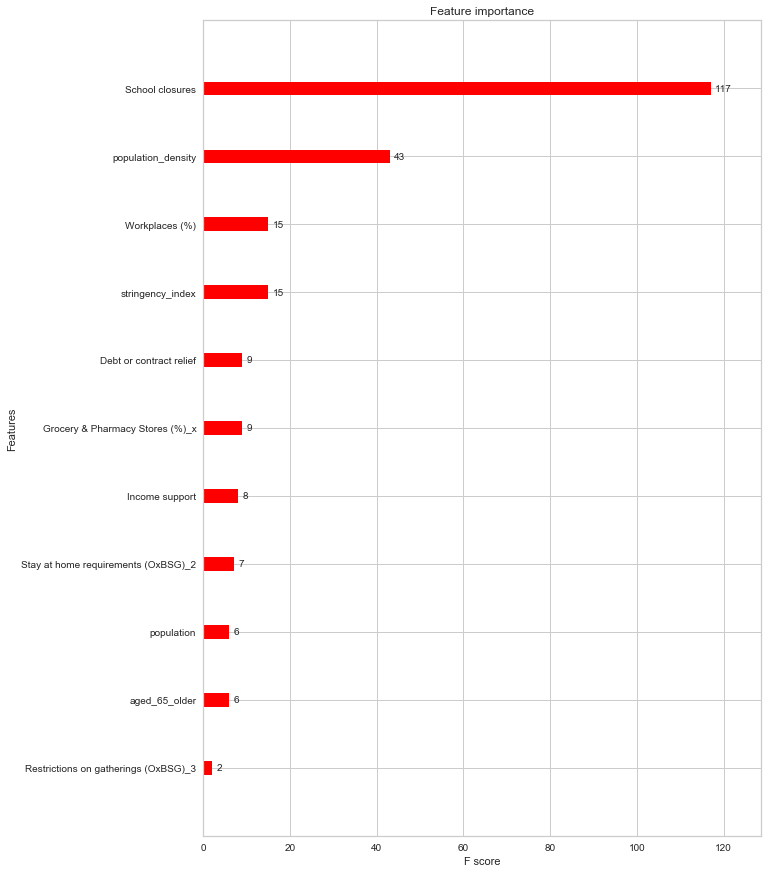

In [38]:
X = country_profiles.drop(['confirmed_cases_diff', 'deaths_diff', 'Code',
                          'recovered_diff', 'deaths', 'recovered', 'confirmed_cases',
                           'total_deaths_per_million', 'total_cases_per_million',
                          'continent', 'location', 'Country/Region', 'Date', 'Lat', 'Long'], axis=1)

y = country_profiles['total_deaths_per_million']

build_importance_plot(X, y)

## Forecasting COVID-19 Cases, Deaths and Recoveries, on a Daily Basis

In [39]:
def create_timeseries_dataset(data, targets):
    
    n = len(data)
    X = data.iloc[0:n-1]
    y = data.iloc[1:n][targets]
    
    return X, y

def compute_cumulative_statistics(data, targets):
    
    for target in targets:
        data[target + '_cum_median'] = data[target].expanding().median()
        data[target + '_cum_mean'] = data[target].expanding().mean()
        data[target + '_cum_var'] = data[target].expanding().var()
        data[target + '_cum_max'] = data[target].cummax()
        
    return data

def create_timeseries_dataset_all_countries(data, targets):
    
    countries = list(data['Country/Region'].unique())
    
    X_data = []
    y_data = []
    
    for country in countries:
        country_data = compute_cumulative_statistics(filter_by_country(data, country), targets)
        X_i, y_i = create_timeseries_dataset(country_data, targets)
        X_data.append(X_i)
        y_data.append(y_i)
    
    X = pd.concat(X_data, axis=0)
    y = np.concatenate(y_data)
    
   # X.rename({target: 'current_' + target}, inplace=True)
    
    return X, y

def train_test_split_by_date(X, y, start_date, cutoff_date, targets=['confirmed_cases_diff', 'deaths_diff', 'recovered_diff']):
    
    targets = [target + '_next' for target in targets]
    data = X
    for index, target in enumerate(targets):
        data[target] = y[:, index]
    train = data[(data['Date'] >= start_date) & (data['Date'] <= cutoff_date)]
    test = data[data['Date'] > cutoff_date]
    
    X_train, y_train = train.drop(targets +  ['Date'], axis=1), train[targets]
    X_test, y_test = test.drop(targets + ['Date'], axis=1), test[targets]
    
    return X_train, X_test, y_train, y_test

## Forecasting Cases

### Preparing the Data

In [40]:
drop_cols = ['Code', 'new_cases','new_deaths', 'total_cases_per_million',
                          'new_cases_per_million', 'total_deaths_per_million', 'total_deaths',
                          'new_deaths_per_million', 'total_cases', 'new_cases', 'new_tests_smoothed',
                          'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_smoothed_per_thousand',
                          'new_tests_per_thousand', 'tests_per_case', 'positive_rate',
                          'continent', 'location', 'iso_code', 'date', 'tests_units']

data_for_timeseries = all_data_by_date_diffs.drop(drop_cols, axis=1)


X, y = create_timeseries_dataset_all_countries(data_for_timeseries, 
                                               targets=['confirmed_cases_diff', 'deaths_diff', 'recovered_diff'])
X.drop('Country/Region', axis=1, inplace=True)
policy_cols = list(filter(lambda x: 'OxBSG' in x, list(X.columns))) + ['School closures', 
                                                                           'Debt or contract relief',
                                                                           'Income support']


In [41]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_squared_error
train_data = defaultdict()

start_date = datetime(2020, 1, 1)
cutoff_date = datetime(2020, 7, 30)
X_train, X_test, y_train, y_test = train_test_split_by_date(X, y, start_date, cutoff_date)
train_data['X_train'], train_data['X_val'], train_data['y_train'], train_data['y_val'] = train_test_split(X_train,
                                                                                                          y_train,
                                                                                                          test_size=0.2)

In [42]:
from sklearn.metrics import r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_pred, y_true):
    
    n = len(y_pred)
    percentage_errors = np.abs(y_pred - y_true) / np.abs(y_true)
    mape = np.average(percentage_errors, dtype=np.float64)
    return mape

def evaluate_model(model, X_test, y_test):
    
    pred = model.predict(X_test)
    r2_value = r2_score(y_test, pred)
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - ((1 - r2_value) * (n - 1)/(n - p - 1))
    print('R2 = {}'.format(r2_value))
    print('Adjusted R2 = {}'.format(adj_r2))
    print('MAE = {}'.format(mean_absolute_error(y_test, pred)))
    print('Average Predicted Value = {}'.format(np.mean(pred)))
    print('Average Actual Value = {}'.format(np.mean(y_test)))
    
    fig = go.Figure(go.Indicator(
    value = r2_value,
    mode = "gauge+number",
    title = {'text': "R^2 Score"},
    gauge = {'bar': {'color': "lightgreen"},
        'axis': {'range': [None, 1]},
             'steps' : [
                 {'range': [0, 0.5], 'color': "lightgray"},
                 {'range': [0.5, 1], 'color': "gray"}],
          }))
    
    fig.show()
    
    fig = go.Figure(go.Indicator(
    value = adj_r2,
    mode = "gauge+number",
    title = {'text': "Adjusted R^2 Score"},
    gauge = {'bar': {'color': "lightgreen"},
        'axis': {'range': [None, 1]},
             'steps' : [
                 {'range': [0, 0.5], 'color': "lightgray"},
                 {'range': [0.5, 1], 'color': "gray"}],
          }))
    
    fig.show()
    
    return pred
    

def evaluate_model_multi_target(model, X_test, y_test):
    
    pred = model.predict(X_test)
    print('Overall R2 = {}'.format(r2_score(y_test, pred)))
    print('MAE = {}'.format(mean_absolute_error(y_test, pred)))
    print('Average Predicted Confirmed Cases = {}'.format(np.mean(pred[:, 0])))
    print('Average Actual Confirmed Cases = {}'.format(np.mean(y_test.values[:, 0])))
    print('R2 for Confirmed Cases = {}'.format(r2_score(pred[:, 0], y_test.values[:, 0])))
    print('Average Predicted Deaths = {}'.format(np.mean(pred[:, 1])))
    print('Average Actual Deaths = {}'.format(np.mean(y_test.values[:, 1])))
    print('R2 for Deaths = {}'.format(r2_score(pred[:, 1], y_test.values[:, 1])))
    print('Average Predicted Recovered = {}'.format(np.mean(pred[:, 2])))
    print('Average Actual Recovered  = {}'.format(np.mean(y_test.values[:, 2])))
    print('R2 for Recovered = {}'.format(r2_score(pred[:, 2], y_test.values[:, 2])))
    #print('MAPE w/o zeros = {} %'.format(100*mean_absolute_percentage_error(pred, y_test)))
    return pred

In [43]:
def plot_residuals(pred, y_test):
    
    residuals = pred - y_test
    residual_df = pd.DataFrame({'residuals': residuals, 'independent_variable': y_test})
    sns.jointplot(x='independent_variable', y='residuals', data=residual_df, height=10)

def plot_residuals_multi_target(pred, y_test, index):
    
    residuals = pred[:, index] - y_test.values[:, index]
    residual_df = pd.DataFrame({'residuals': residuals, 'predicted_values': pred[:, index]})
    sns.jointplot(x='predicted_values', y='residuals', data=residual_df, height=10)

### Writing a Custom Data Cleaning Transformer

In [44]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

def clean_data(X):
    
    policy_cols = list(filter(lambda x: 'OxBSG' in x, list(X.columns))) + ['School closures', 
                                                                           'Debt or contract relief',
                                                                           'Income support']
    X_one_hot = pd.get_dummies(X, columns=policy_cols)
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_one_hot)
    
    return X_imputed

data_cleaner = FunctionTransformer(clean_data)

In [45]:
from sklearn.preprocessing import OneHotEncoder    
from sklearn.base import BaseEstimator, TransformerMixin


class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, encode_cols):
        
        self.encode_cols = encode_cols
        self.col_mapping_dict = defaultdict()
        self.one_hot_cols = defaultdict()
        

    def fit(self, X, y=None):
        
        for col in self.encode_cols:
            unique_values = list(X[col].unique())
            self.col_mapping_dict[col] = unique_values
            self.one_hot_cols[col] = []
            for value in unique_values:
                self.one_hot_cols[col] = self.one_hot_cols[col] + [col + '_' + str(value)]
        
        return self
        
    
    def _one_hot_encode(self, target, value):
        
        return int(target == value);
    
    def transform(self, X):
        
        X_copy = X
        for col in self.encode_cols:
            #print('Working on ', col)
            targets = self.col_mapping_dict[col]
            for target in targets:
                one_hot_col = col + '_' + str(target)
                X_copy[one_hot_col] = X_copy[col].map(lambda x: self._one_hot_encode(target, x))
        
        return X_copy.drop(self.encode_cols, axis=1)
            
        

def make_categorical(data, cat_cols):
    
    for col in cat_cols:
        data[col] = data[col].astype('category')
    
    return data

## Using Deep Learning

### Predicting Cases

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoLarsCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone

mlp_pipeline_cases = Pipeline([('encoder', CustomOneHotEncoder(encode_cols=policy_cols)),
                                      ('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler()),
                                      ('mlp', MLPRegressor(hidden_layer_sizes=[90, 90],
                                                           verbose=True))], verbose=True)

mlp_pipeline_cases.fit(X_train, y_train['confirmed_cases_diff_next'])

[Pipeline] ........... (step 1 of 4) Processing encoder, total=   1.5s
[Pipeline] ........... (step 2 of 4) Processing imputer, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
Iteration 1, loss = 7115534.71758841
Iteration 2, loss = 3513344.09075533
Iteration 3, loss = 1851176.35558211
Iteration 4, loss = 1416244.08134877
Iteration 5, loss = 1077468.92101290
Iteration 6, loss = 815408.20103936
Iteration 7, loss = 629106.37044322
Iteration 8, loss = 515473.41151467
Iteration 9, loss = 448773.50500069
Iteration 10, loss = 398637.10149761
Iteration 11, loss = 372951.50094173
Iteration 12, loss = 355158.97461787
Iteration 13, loss = 332002.08074808
Iteration 14, loss = 319651.37338386
Iteration 15, loss = 311815.36965098
Iteration 16, loss = 300542.62874212
Iteration 17, loss = 291583.89781321
Iteration 18, loss = 289159.94337046
Iteration 19, loss = 284499.35041079
Iteration 20, loss = 279554.39145825
Iteration 21, loss = 274412.29739330
Iteration 22, 

Pipeline(memory=None,
         steps=[('encoder',
                 CustomOneHotEncoder(encode_cols=['Cancel public events '
                                                  '(OxBSG)',
                                                  'Restrictions on gatherings '
                                                  '(OxBSG)',
                                                  'Public information '
                                                  'campaigns (OxBSG)',
                                                  'Close public transport '
                                                  '(OxBSG)',
                                                  'Workplace Closures (OxBSG)',
                                                  'Stay at home requirements '
                                                  '(OxBSG)',
                                                  'Contact tracing (OxBSG)',
                                                  'Restrictions on internal '
                   

In [47]:
pred = evaluate_model(mlp_pipeline_cases, X_test, y_test['confirmed_cases_diff_next'])

R2 = 0.9535389677965833
Adjusted R2 = 0.9533162653994781
MAE = 304.2035738185607
Average Predicted Value = 347.47755822359585
Average Actual Value = 289.62971553610504


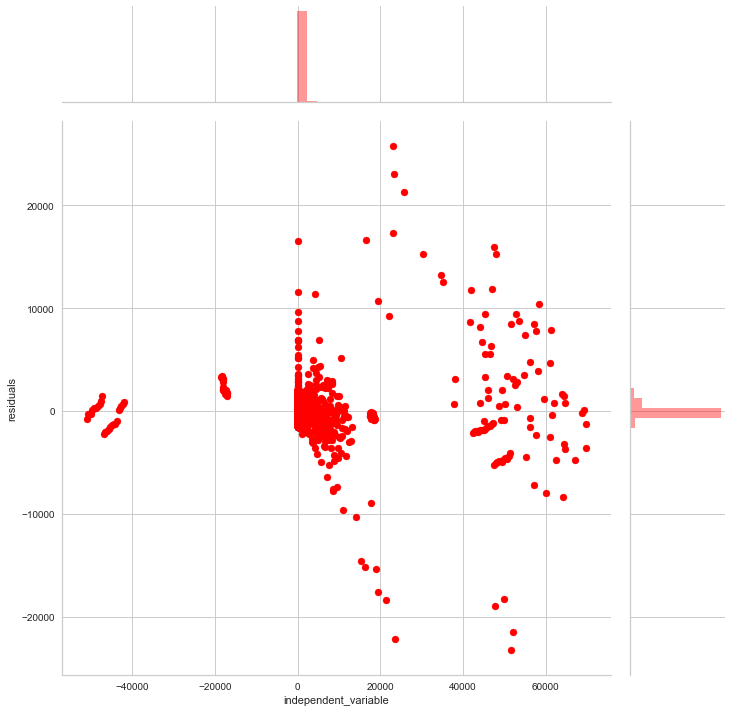

In [48]:
plot_residuals(pred, y_test['confirmed_cases_diff_next'])

In [49]:
X, y = create_timeseries_dataset_all_countries(data_for_timeseries, 
                                               targets=['confirmed_cases_diff', 'deaths_diff', 'recovered_diff'])
X.drop(['Country/Region', 'Date'], axis=1, inplace=True)
mlp_pipeline_cases = clone(mlp_pipeline_cases)
mlp_pipeline_cases.fit(X, y[:, 0])

[Pipeline] ........... (step 1 of 4) Processing encoder, total=   2.1s
[Pipeline] ........... (step 2 of 4) Processing imputer, total=   0.6s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
Iteration 1, loss = 5828237.60211223
Iteration 2, loss = 2235897.96022726
Iteration 3, loss = 1666808.03667160
Iteration 4, loss = 1192106.17936269
Iteration 5, loss = 803187.84100298
Iteration 6, loss = 559379.68246578
Iteration 7, loss = 435081.59275304
Iteration 8, loss = 372958.73781351
Iteration 9, loss = 341925.97220880
Iteration 10, loss = 323363.12606194
Iteration 11, loss = 310514.92927319
Iteration 12, loss = 303317.66187321
Iteration 13, loss = 290913.59913298
Iteration 14, loss = 285957.01300810
Iteration 15, loss = 278244.91255694
Iteration 16, loss = 273962.40840013
Iteration 17, loss = 268918.42019647
Iteration 18, loss = 265922.58669786
Iteration 19, loss = 265198.20184100
Iteration 20, loss = 260048.82492218
Iteration 21, loss = 256851.53456422
Iteration 22, l

Pipeline(memory=None,
         steps=[('encoder',
                 CustomOneHotEncoder(encode_cols=['Cancel public events '
                                                  '(OxBSG)',
                                                  'Restrictions on gatherings '
                                                  '(OxBSG)',
                                                  'Public information '
                                                  'campaigns (OxBSG)',
                                                  'Close public transport '
                                                  '(OxBSG)',
                                                  'Workplace Closures (OxBSG)',
                                                  'Stay at home requirements '
                                                  '(OxBSG)',
                                                  'Contact tracing (OxBSG)',
                                                  'Restrictions on internal '
                   

In [50]:
dump(mlp_pipeline_cases, './models/mlp_pipeline_cases.joblib')

['./models/mlp_pipeline_cases.joblib']

### Predicting Deaths

In [51]:
mlp_pipeline_deaths = Pipeline([('encoder', CustomOneHotEncoder(encode_cols=policy_cols)),
                                      ('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler()),
                                      ('mlp', MLPRegressor(hidden_layer_sizes=[90, 90], 
                                                           early_stopping=True,
                                                           verbose=True))], verbose=True)

mlp_pipeline_deaths.fit(X_train, y_train['deaths_diff_next'])

[Pipeline] ........... (step 1 of 4) Processing encoder, total=   1.5s
[Pipeline] ........... (step 2 of 4) Processing imputer, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
Iteration 1, loss = 4999.67360115
Validation score: 0.725446
Iteration 2, loss = 1835.51187126
Validation score: 0.854527
Iteration 3, loss = 1186.03236463
Validation score: 0.864021
Iteration 4, loss = 1079.93502995
Validation score: 0.867140
Iteration 5, loss = 1051.78080510
Validation score: 0.865897
Iteration 6, loss = 1031.61168966
Validation score: 0.870613
Iteration 7, loss = 1005.80481323
Validation score: 0.870661
Iteration 8, loss = 992.48561631
Validation score: 0.870306
Iteration 9, loss = 994.54816472
Validation score: 0.868862
Iteration 10, loss = 984.56142751
Validation score: 0.866698
Iteration 11, loss = 965.53191353
Validation score: 0.873434
Iteration 12, loss = 953.55183980
Validation score: 0.875539
Iteration 13, loss = 974.13224623
Validation score: 0.872

Pipeline(memory=None,
         steps=[('encoder',
                 CustomOneHotEncoder(encode_cols=['Cancel public events '
                                                  '(OxBSG)',
                                                  'Restrictions on gatherings '
                                                  '(OxBSG)',
                                                  'Public information '
                                                  'campaigns (OxBSG)',
                                                  'Close public transport '
                                                  '(OxBSG)',
                                                  'Workplace Closures (OxBSG)',
                                                  'Stay at home requirements '
                                                  '(OxBSG)',
                                                  'Contact tracing (OxBSG)',
                                                  'Restrictions on internal '
                   

In [52]:
pred = evaluate_model(mlp_pipeline_deaths, X_test, y_test['deaths_diff_next'])

R2 = 0.7816879109151427
Adjusted R2 = 0.7806414721416048
MAE = 10.843103281044804
Average Predicted Value = 1.9604487861525115
Average Actual Value = 6.397680525164114


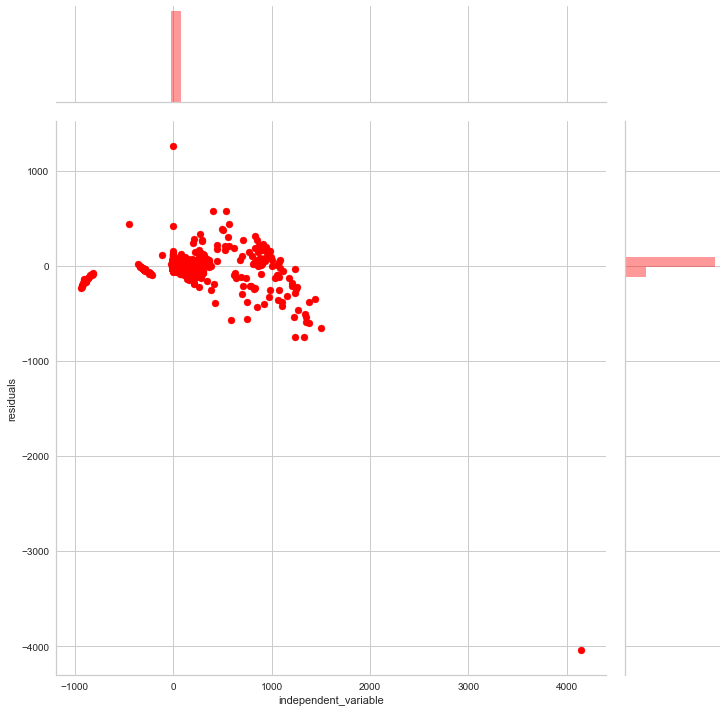

In [53]:
plot_residuals(pred, y_test['deaths_diff_next'])

In [54]:
X, y = create_timeseries_dataset_all_countries(data_for_timeseries, 
                                               targets=['confirmed_cases_diff', 'deaths_diff', 'recovered_diff'])
X.drop(['Country/Region', 'Date'], axis=1, inplace=True)
mlp_pipeline_deaths = clone(mlp_pipeline_deaths)
mlp_pipeline_deaths.fit(X, y[:, 1])

[Pipeline] ........... (step 1 of 4) Processing encoder, total=   2.3s
[Pipeline] ........... (step 2 of 4) Processing imputer, total=   0.6s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
Iteration 1, loss = 3182.46641534
Validation score: 0.835839
Iteration 2, loss = 1173.08467979
Validation score: 0.926545
Iteration 3, loss = 997.27675475
Validation score: 0.923921
Iteration 4, loss = 951.01112599
Validation score: 0.937674
Iteration 5, loss = 930.67823287
Validation score: 0.939391
Iteration 6, loss = 912.11867147
Validation score: 0.938434
Iteration 7, loss = 898.46219017
Validation score: 0.940381
Iteration 8, loss = 891.15551891
Validation score: 0.938323
Iteration 9, loss = 884.74607497
Validation score: 0.938747
Iteration 10, loss = 877.35637149
Validation score: 0.930004
Iteration 11, loss = 883.97685979
Validation score: 0.945056
Iteration 12, loss = 855.86060074
Validation score: 0.944635
Iteration 13, loss = 855.05728354
Validation score: 0.945629
I

Pipeline(memory=None,
         steps=[('encoder',
                 CustomOneHotEncoder(encode_cols=['Cancel public events '
                                                  '(OxBSG)',
                                                  'Restrictions on gatherings '
                                                  '(OxBSG)',
                                                  'Public information '
                                                  'campaigns (OxBSG)',
                                                  'Close public transport '
                                                  '(OxBSG)',
                                                  'Workplace Closures (OxBSG)',
                                                  'Stay at home requirements '
                                                  '(OxBSG)',
                                                  'Contact tracing (OxBSG)',
                                                  'Restrictions on internal '
                   

In [55]:
dump(mlp_pipeline_deaths, './models/mlp_pipeline_deaths.joblib')

['./models/mlp_pipeline_deaths.joblib']

### Predicting Recovered Cases

In [56]:
mlp_pipeline_recovered = Pipeline([('encoder', CustomOneHotEncoder(encode_cols=policy_cols)),
                                      ('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler()),
                                      ('mlp', MLPRegressor(hidden_layer_sizes=[90, 90], 
                                                           early_stopping=True,
                                                           verbose=True))], verbose=True)

mlp_pipeline_recovered.fit(X_train, y_train['recovered_diff_next'])

[Pipeline] ........... (step 1 of 4) Processing encoder, total=   1.2s
[Pipeline] ........... (step 2 of 4) Processing imputer, total=   0.3s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
Iteration 1, loss = 3026042.47924954
Validation score: 0.214254
Iteration 2, loss = 2042154.39969345
Validation score: 0.588520
Iteration 3, loss = 1490687.73200276
Validation score: 0.684403
Iteration 4, loss = 1317966.63815272
Validation score: 0.730520
Iteration 5, loss = 1200143.44250765
Validation score: 0.761390
Iteration 6, loss = 1112615.07241296
Validation score: 0.776266
Iteration 7, loss = 1063675.08274260
Validation score: 0.785101
Iteration 8, loss = 1041608.20820851
Validation score: 0.786578
Iteration 9, loss = 1026062.83503003
Validation score: 0.788850
Iteration 10, loss = 1022136.88308241
Validation score: 0.786992
Iteration 11, loss = 1011864.78688635
Validation score: 0.782066
Iteration 12, loss = 1004042.08637720
Validation score: 0.788123
Iteration 13, lo

Pipeline(memory=None,
         steps=[('encoder',
                 CustomOneHotEncoder(encode_cols=['Cancel public events '
                                                  '(OxBSG)',
                                                  'Restrictions on gatherings '
                                                  '(OxBSG)',
                                                  'Public information '
                                                  'campaigns (OxBSG)',
                                                  'Close public transport '
                                                  '(OxBSG)',
                                                  'Workplace Closures (OxBSG)',
                                                  'Stay at home requirements '
                                                  '(OxBSG)',
                                                  'Contact tracing (OxBSG)',
                                                  'Restrictions on internal '
                   

In [57]:
pred = evaluate_model(mlp_pipeline_recovered, X_test, y_test['recovered_diff_next'])

R2 = 0.7199351672121774
Adjusted R2 = 0.7185927280400635
MAE = 471.96113155855153
Average Predicted Value = 402.3372295597609
Average Actual Value = 231.75024070021882


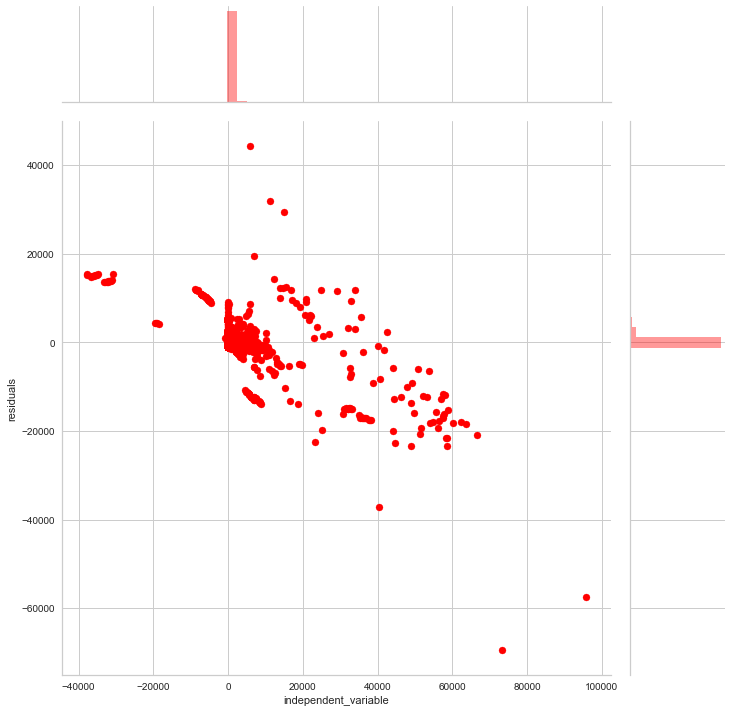

In [58]:
plot_residuals(pred, y_test['recovered_diff_next'])

In [59]:
X, y = create_timeseries_dataset_all_countries(data_for_timeseries, 
                                               targets=['confirmed_cases_diff', 'deaths_diff', 'recovered_diff'])
X.drop(['Country/Region', 'Date'], axis=1, inplace=True)
mlp_pipeline_recovered = clone(mlp_pipeline_recovered)
mlp_pipeline_recovered.fit(X, y[:, 2])

[Pipeline] ........... (step 1 of 4) Processing encoder, total=   2.2s
[Pipeline] ........... (step 2 of 4) Processing imputer, total=   0.6s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
Iteration 1, loss = 3234338.82007998
Validation score: 0.453690
Iteration 2, loss = 1673946.29280330
Validation score: 0.579905
Iteration 3, loss = 1414082.96228850
Validation score: 0.638353
Iteration 4, loss = 1225019.38601956
Validation score: 0.683831
Iteration 5, loss = 1083606.65982738
Validation score: 0.721034
Iteration 6, loss = 993750.65596498
Validation score: 0.738622
Iteration 7, loss = 942558.52619995
Validation score: 0.758066
Iteration 8, loss = 918182.49960647
Validation score: 0.764702
Iteration 9, loss = 901674.29456984
Validation score: 0.770719
Iteration 10, loss = 884764.85120345
Validation score: 0.777155
Iteration 11, loss = 877409.91209101
Validation score: 0.779424
Iteration 12, loss = 865310.56187925
Validation score: 0.783547
Iteration 13, loss = 85

Pipeline(memory=None,
         steps=[('encoder',
                 CustomOneHotEncoder(encode_cols=['Cancel public events '
                                                  '(OxBSG)',
                                                  'Restrictions on gatherings '
                                                  '(OxBSG)',
                                                  'Public information '
                                                  'campaigns (OxBSG)',
                                                  'Close public transport '
                                                  '(OxBSG)',
                                                  'Workplace Closures (OxBSG)',
                                                  'Stay at home requirements '
                                                  '(OxBSG)',
                                                  'Contact tracing (OxBSG)',
                                                  'Restrictions on internal '
                   

In [60]:
dump(mlp_pipeline_recovered, './models/mlp_pipeline_recovered.joblib')

['./models/mlp_pipeline_recovered.joblib']

## Generating and Visualizing Daily Forecasts for COVID-19 in Different Countries

### Loading Models and Defining Utility Functions

In [61]:
cases_model = load('./models/mlp_pipeline_cases.joblib')
deaths_model = load('./models/mlp_pipeline_deaths.joblib')
recovered_model = load('./models/mlp_pipeline_recovered.joblib')

In [62]:
drop_cols = ['Code', 'new_cases','new_deaths', 'total_cases_per_million',
                          'new_cases_per_million', 'total_deaths_per_million', 'total_deaths',
                          'new_deaths_per_million', 'total_cases', 'new_cases', 'new_tests_smoothed',
                          'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_smoothed_per_thousand',
                          'new_tests_per_thousand', 'tests_per_case', 'positive_rate', 'date',
                          'continent', 'location', 'iso_code', 'Date', 'tests_units', 'Country/Region']

stringency_index_cols = ['Cancel public events (OxBSG)', 'Restrictions on gatherings (OxBSG)',
                         'Public information campaigns (OxBSG)', 'Workplace Closures (OxBSG)',
                         'Stay at home requirements (OxBSG)', 'Restrictions on internal movement (OxBSG)',
                         'International travel controls (OxBSG)', 'Testing policy (OxBSG)',
                         'School closures']

def set_policy_cols(data, policy_dict):
    
    if policy_dict is None:
        
        return data
    
    else:
        
        for col, value in policy_dict.items():
            data[col] = data[col].map(lambda x: value)
    
        return data
    
def days_to_predict(data, country, future_date):
    
    country_data = filter_by_country(data, country=country)
    latest_date = country_data['Date'].max()
    
    time_diff = future_date - latest_date
    
    return time_diff.days
    

def create_max_value_dict(data, policy_cols):
    
    data_dict = defaultdict()
    
    for col in policy_cols:
        data_dict[col] = data[col].max()
    
    return data_dict

max_value_dict = create_max_value_dict(all_data_by_date_diffs, policy_cols)

def normalize(policy_col, value, max_value_dict):
    
    return 100.0 * (value / max_value_dict[policy_col])

def calculate_stringency_index(data, policy_cols):
    
    normalized_scores = []
    for col in policy_cols:
        normalized_scores.append(normalize(col, data[col].values[-1], max_value_dict))
    
    return np.mean(np.array(normalized_scores))

def get_latest_data(data, country):
    
    country_data = filter_by_country(data, country=country)
    latest_date = country_data['Date'].max()
    latest_data = country_data[country_data['Date'] == latest_date]
    
    return latest_data
            

def predict_future(data, country, future_date, drop_cols, policy_dict):
    
    country_data = filter_by_country(data, country=country)
    forecast_results = pd.DataFrame()
    
    n_days = days_to_predict(data, country, future_date)
    
    for i in range(n_days):
        country_data_stats = compute_cumulative_statistics(country_data, 
                                                 targets=['confirmed_cases_diff',
                                                          'deaths_diff',
                                                          'recovered_diff'])
        if i == 0:
            latest_date = country_data_stats['Date'].max()
            latest_data = country_data_stats[country_data['Date'] == latest_date]
            new_date = latest_date + timedelta(days=1)
        else:
            latest_date = forecast_results['Date'].max()
            latest_data = country_data_stats[country_data_stats['Date'] == latest_date]
            new_date = latest_date + timedelta(days=1)  
        
        latest_data = set_policy_cols(latest_data, policy_dict)
        cases_diff = cases_model.predict(latest_data.drop(drop_cols, axis=1))
        deaths_diff = deaths_model.predict(latest_data.drop(drop_cols, axis=1))
        recovered_diff = recovered_model.predict(latest_data.drop(drop_cols, axis=1))
        cases_pred = cases_diff + latest_data['confirmed_cases']
        deaths_pred = deaths_diff + latest_data['deaths']
        recovered_pred = recovered_diff + latest_data['recovered']
        stringency_index = calculate_stringency_index(latest_data, stringency_index_cols)
        
        #print(latest_data.info())
        forecast_data = set_policy_cols(latest_data, policy_dict)
        forecast_data['confirmed_cases'] = cases_pred
        forecast_data['deaths'] = deaths_pred
        forecast_data['recovered'] = recovered_pred
        forecast_data['confirmed_cases_diff'] = cases_diff
        forecast_data['deaths_diff'] = deaths_diff
        forecast_data['recovered_diff'] = recovered_diff
        forecast_data['stringency_index'] = stringency_index
        forecast_data['Date'] = new_date
        country_data = country_data.append(forecast_data)
        
        forecast_results = forecast_results.append(forecast_data)
    
    return forecast_results

def plot_forecast(forecast_results, country, columns):
    
    plt.figure(figsize=(15, 10))
    for column in columns:
        plt.plot(forecast_results['Date'], forecast_results[column], label=column)
    plt.xlabel('Date')
    plt.ylabel('Statistics')
    plt.legend(loc='best')
    plt.title('Forecast for {}'.format(country))
    plt.show()

default_columns = ['confirmed_cases', 'deaths', 'recovered']

### Forecasts for the US

In [63]:
future_date = datetime(2021, 1, 1)
start_date = datetime(2020, 9, 3)

In [64]:
us_predictions = predict_future(all_data_by_date_diffs, 
                                    'US', future_date=future_date, 
                                    drop_cols=drop_cols, policy_dict=None)

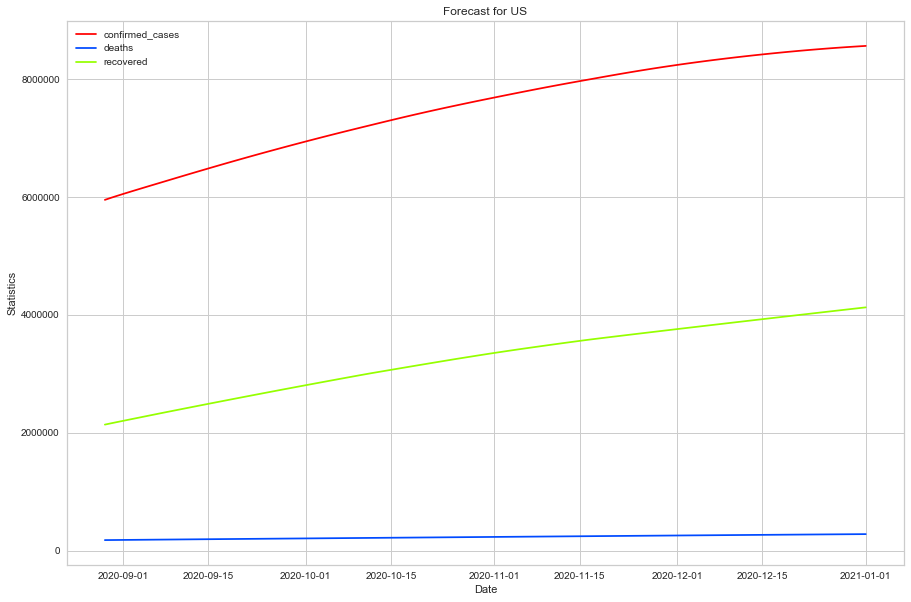

In [65]:
plot_forecast(us_predictions, country='US', columns=default_columns)

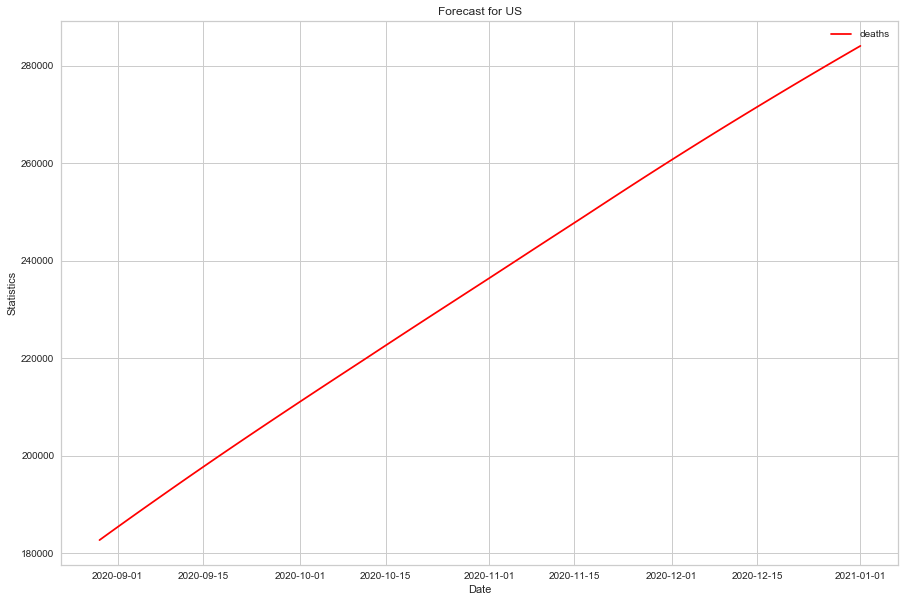

In [66]:
plot_forecast(us_predictions, country='US', columns=['deaths'])

### Predictions for All Countries

In [ ]:
predictions_dict = defaultdict()
all_countries = list(all_data_by_date_diffs['Country/Region'].unique())

pbar = pyprind.ProgBar(len(all_countries), title='Generating World COVID Forecasts')

for country in all_countries:
    #print(country)
    predictions_dict[country] = predict_future(all_data_by_date_diffs, 
                                    country, future_date=future_date, 
                                    drop_cols=drop_cols, policy_dict=None)
    pbar.update()

Generating World COVID Forecasts
0% [##########################    ] 100% | ETA: 00:06:03

In [ ]:
def create_future_df(predictions_dict):
    
    
    return pd.concat(list(predictions_dict.values()))


forecast_df = create_future_df(predictions_dict)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df_same_start = forecast_df[forecast_df['Date'] >= start_date]
forecast_df_same_start['Date'] = forecast_df_same_start['Date'].map(lambda x: str(x))

### Visualizing the Future of COVID-19

In [ ]:
fig = px.choropleth(forecast_df_same_start, 
                    animation_frame = 'Date',
                    locations = 'Country/Region', 
                    locationmode = 'country names',
                    color_continuous_scale = "matter",
                    color = 'confirmed_cases',
                    range_color=(0,1.5e7),
                    title='COVID-19 Forecasts')

fig.show()